In [3]:
import pandas as pd
import datetime
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

In [55]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

## 定数の設定

分析全体を通して使う定数は大文字で定義しておくのがルール。

In [4]:
# https://www.quandl.com/api/v3/datasets/TSE/{code}/data.csv

SHARES = ["TSE-1662", "TSE-8267", "TSE-7203", "TSE-9020"]
# SHARES = ["TSE-1662", "TSE-1605", "TSE-8267", "TSE-7203", "TSE-9020"]

START = datetime.datetime(2017,1,1)
END = datetime.datetime(2018,1,1)

## 読み込み・前処理

必要なカラム、期間を絞って使いやすい形のデータフレームにする。

In [5]:
for i, s in enumerate(SHARES):
    data = pd.read_csv(f'{s}.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    cond = (data['Date'] >= START) & (data['Date'] < END)    
    if i == 0: 
        df = data[cond].sort_values('Date', ascending=True).set_index('Date')[['Close']]
        df = df.rename(columns={"Close":f"{s}"})
    else:
        df[s] = data[cond].sort_values('Date', ascending=True).set_index('Date')['Close']

In [6]:
df.head()

,TSE-1662,TSE-8267,TSE-7203,TSE-9020
Date,,,,
2017-01-04,2672.0,1684.0,7097.0,10320.0
2017-01-05,2645.0,1698.5,7049.0,10375.0
2017-01-06,2632.0,1699.5,6930.0,10510.0
2017-01-10,2586.0,1688.0,6861.0,10400.0
2017-01-11,2596.0,1699.0,6912.0,10495.0


## 時系列の分析

- コレログラム：ラグとの相関。青いところはバートレット検定による相関無しと判断される範囲
- LjungBox検定：自己回帰の有無の検定。意味のある自己回帰であるかを判断したい。

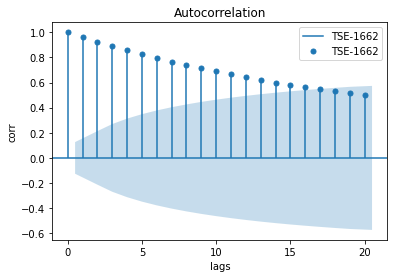

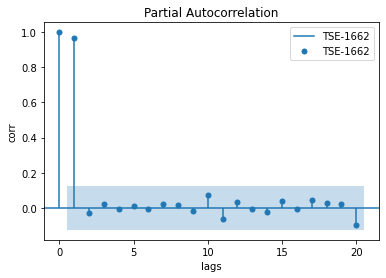

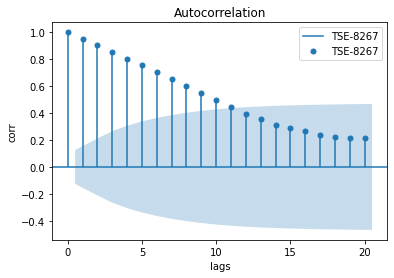

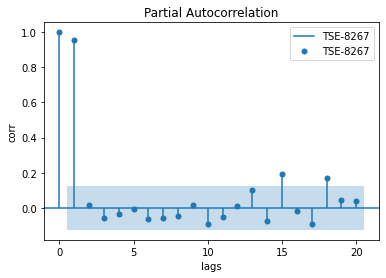

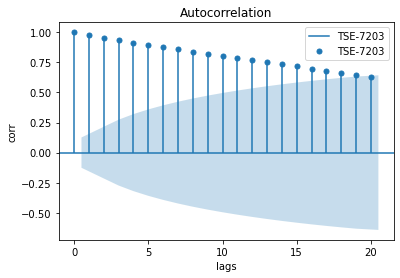

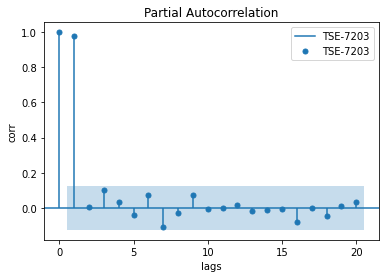

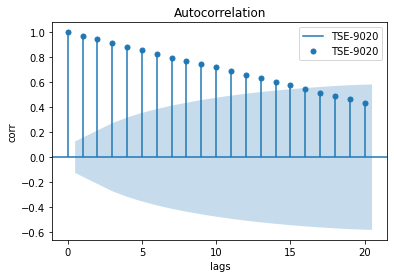

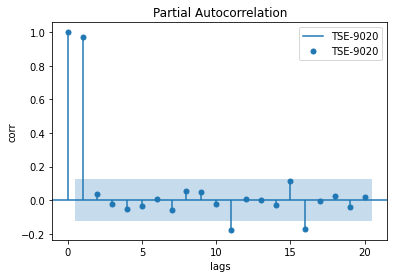

In [28]:
# 価格の自己相関
for i, s in enumerate(SHARES):
    arr = df[s].values
    #自己相関係数のプロット
    sm.graphics.tsa.plot_acf(arr, lags=20, label=s);
    plt.xlabel('lags')
    plt.ylabel('corr')
    plt.legend()
    
    #偏自己相関係数のプロット
    sm.graphics.tsa.plot_pacf(arr, lags=20, label=s);
    plt.xlabel('lags')
    plt.ylabel('corr')
    plt.legend()
    plt.show()


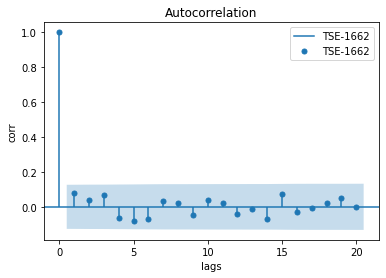

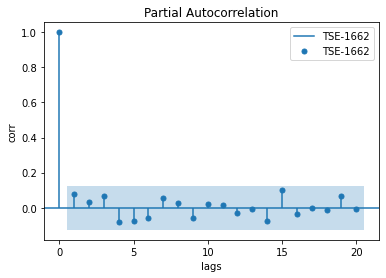

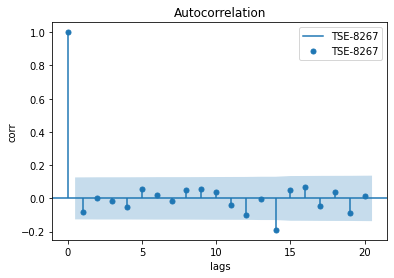

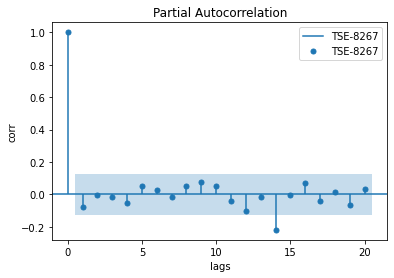

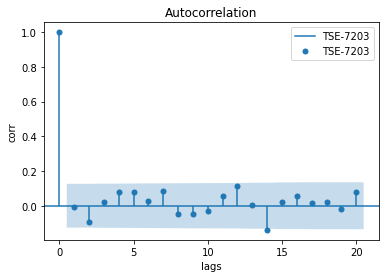

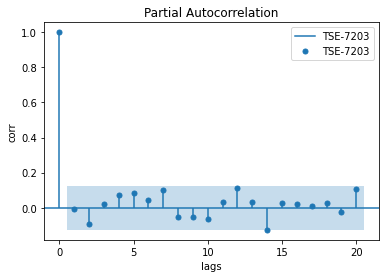

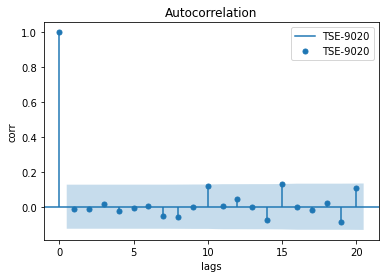

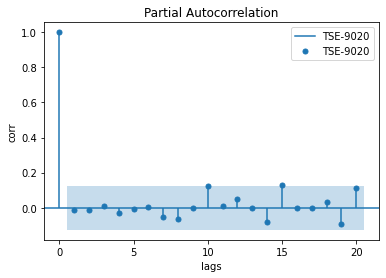

In [29]:
# 対数収益率の自己相関
for i, s in enumerate(SHARES):
    arr = np.log(df[s]).diff()[1:].values
    #自己相関係数のプロット
    sm.graphics.tsa.plot_acf(arr, lags=20, label=s);
    plt.xlabel('lags')
    plt.ylabel('corr')
    plt.legend()
    
    #偏自己相関係数のプロット
    sm.graphics.tsa.plot_pacf(arr, lags=20, label=s);
    plt.xlabel('lags')
    plt.ylabel('corr')
    plt.legend()
    plt.show()

In [52]:
# Ljung-Box検定
for i, s in enumerate(SHARES):
    print(f'----{s}----')
    arr = np.log(df[s]).diff()[1:].values
    result = acorr_ljungbox(arr, lags=20)
    lag = 1
    for lb, p in zip(result[0], result[1]):
        if p < 0.05:
            print(lag, lb, p)
        lag += 1

----TSE-1662----
----TSE-8267----
----TSE-7203----
----TSE-9020----


## 統計モデリング（SARIMAX）

- S:Seasonality, 季節性、月や曜日などの周期性
- AR:Auto Regressive、自己回帰、系列自身の過去実績に依存する。定常性
- I; Integrated, 和分過程、差分が本質的な変動
- MA: Moving Average、（過去のノイズの）移動平均、過去の振れ幅に依存する。ていじょうせい
- X：外生変数

In [96]:
arr = df[s].values
model = sm.tsa.SARIMAX(arr, order=(1,1,1), seasonal_order=(0, 0, 0, 0), trend='c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  242
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1218.327
Date:                Sat, 13 Mar 2021   AIC                           2444.654
Time:                        19:10:50   BIC                           2458.593
Sample:                             0   HQIC                          2450.269
                                - 242                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5893      1.830      0.322      0.747      -2.997       4.175
ar.L1          0.3925      0.698      0.562      0.574      -0.975       1.760
ma.L1         -0.3142      0.720     -0.437      0.662      -1.724       1.096
sigma2      1440.8387    105.989     13.594      0.000    1233.103    1648.574
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                15.81
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.25
Prob(H) (two-sided):                  0.54   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

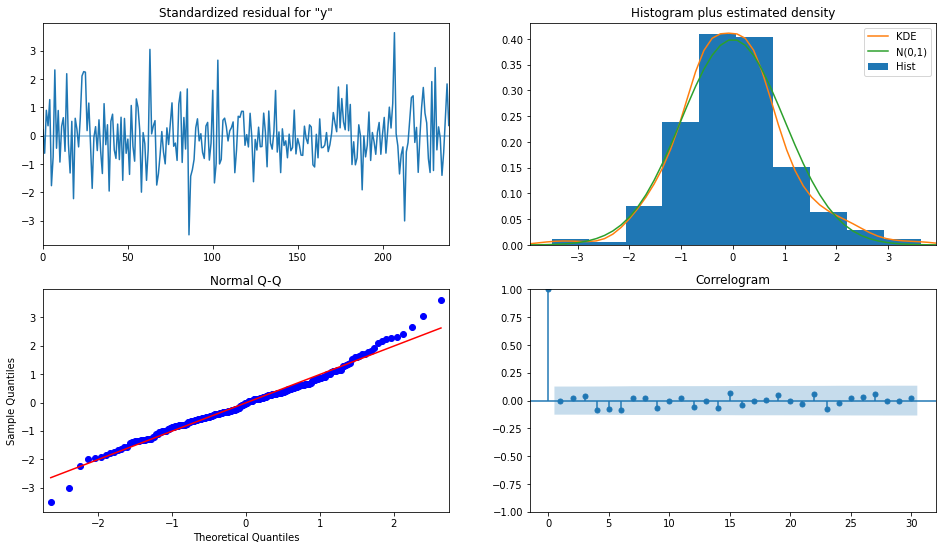

In [93]:
fig = plt.figure(figsize=(16,9))
fig = result.plot_diagnostics(fig=fig, lags=30)

In [77]:
# arr = df[s].values
arr = np.log(df[s]).diff()[1:].values
model = sm.tsa.SARIMAX(arr, order=((1,5,12,13),0, 0), trend='c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  241
Model:             SARIMAX([1, 5, 12, 13], 0, 0)   Log Likelihood                 665.535
Date:                           Sat, 13 Mar 2021   AIC                          -1319.071
Time:                                   18:38:58   BIC                          -1298.162
Sample:                                        0   HQIC                         -1310.647
                                           - 241                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.001      0.351      0.726      -0.002       0.002
ar.L1          0.0713      0.064      1.120      0.263      -0.054       0.196
ar.L5         -0.0773      0.066     -1.176      0.240      -0.206       0.052
ar.L12        -0.0455      0.076     -0.603      0.547      -0.194       0.103
ar.L13         0.0003      0.074      0.004      0.997      -0.144       0.145
sigma2         0.0002   1.83e-05     12.754      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                11.54
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.26
Prob(H) (two-sided):                  0.87   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

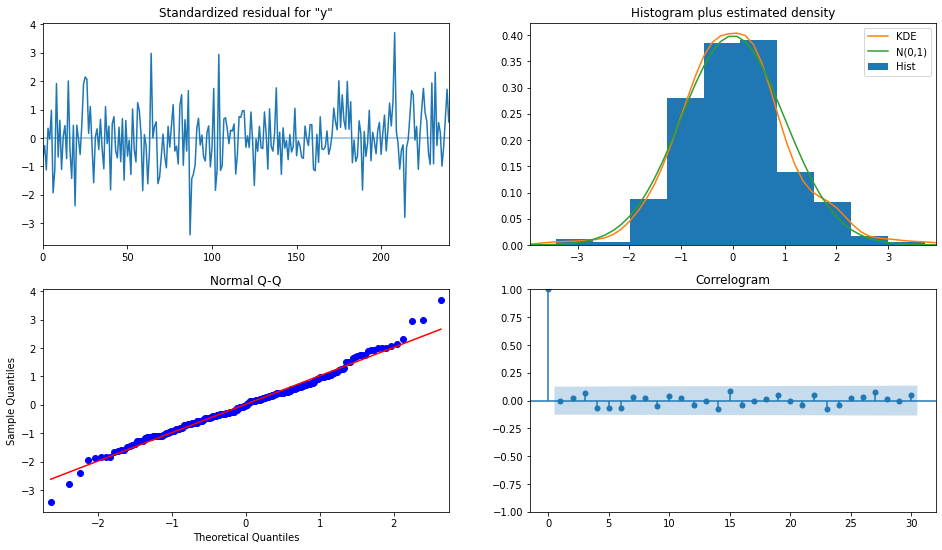

In [68]:
fig = plt.figure(figsize=(16,9))
fig = result.plot_diagnostics(fig=fig, lags=30)

In [56]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [57]:
arr = df[s].values
results = sm.tsa.stattools.adfuller(arr)
print('ADF Statistic: %f' % results[0])
print('P-Value: %f' % results[1])

ADF Statistic: -0.949202
P-Value: 0.771338


In [58]:
adf_test(arr)

Results of Dickey-Fuller Test:
Test Statistic                  -0.949202
p-value                          0.771338
#Lags Used                       1.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64
